# Задание на обработку данных для аналитика ЭКОПСИ

In [2]:
# Импортирование библиотек

import glob

import numpy as np
import pandas as pd

from scipy.stats import spearmanr

from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer

# Часть 1: Техническая
# 1.1 Загрузка данных

In [3]:
# Загрузка всех данных из папки 'data' в одну переменную 'df'

all_files = glob.iglob(r'data\*.csv')
df_from_each_file = (pd.read_csv(file, sep=';') for file in all_files)
df = pd.concat(df_from_each_file, ignore_index=True)

df.head(3)

,entry_id,country,description,designation,points,price,province,region,taster_name,title,variety,winery
0,119966,Argentina,Raspberry and cassis aromas are fresh and upri...,Pedernal,90,43.0,Other,San Juan,Michael Schachner,Finca Las Moras 2010 Pedernal Malbec (San Juan),Malbec,Finca Las Moras
1,119956,Argentina,Compared to the regular 2006 Malbec from Chaka...,Reserve,91,25.0,Mendoza Province,Luján de Cuyo,Michаеl Schаchnеr,Chakana 2006 Reserve Malbec (Luján de Cuyo),Malbec,Chakana
2,119950,Argentina,Andeluna's top wines tend to be ripe and plump...,Pasionado,91,55.0,Mendoza Province,Uco Valley,Michael Schachner,Andeluna 2004 Pasionado Red (Uco Valley),Red Blend,Andeluna


In [4]:
print(f'Строк: {df.shape[0]}\nСтолбцов: {df.shape[1]}')

Строк: 149908
Столбцов: 12


# 1.2 Очистка данных

In [5]:
# Удаление повторяющихся строк

df.drop_duplicates(subset='entry_id', inplace=True)

print(f'Уникальных строк: {df.shape[0]}')

Уникальных строк: 119929


In [6]:
# Рассчет количества кириллических символов в столбце 'taster_name'

summ = 0

for row in df['taster_name']:
    for char in str(row):
        if char.isalpha() and ord(char) not in range(ord('A'), ord('z')+1):
            summ += 1

print(f'Всего кириллических символов: {summ}')

Всего кириллических символов: 104229


In [7]:
# Замена кириллицы латиницей

df = df.replace({'О': 'O', 'о': 'o',
                 'Е': 'E', 'е': 'e',
                 'А': 'A', 'а': 'a'}, regex=True)

In [8]:
# Повторная проверка

summ = 0

for row in df['taster_name']:
    for char in str(row):
        if char.isalpha() and ord(char) not in range(ord('A'), ord('z')+1):
            summ += 1

print(f'Всего кириллических символов: {summ}')

Всего кириллических символов: 0


In [9]:
# Количество уникальных строк в столбце 'taster_name'

print(f'Уникальных строк в столбце "taster_name", включая nan: {df["taster_name"].nunique(dropna=False)}')

Уникальных строк в столбце "taster_name", включая nan: 20


# 1.3 Эксплораторный анализ

In [10]:
# Общая статистическая информация о данных

df.describe().drop('entry_id', axis=1)

,points,price
count,119929.000000,111538.000000
mean,88.442145,35.626109
std,3.093275,42.112910
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


По заданию требуется вывести лишь среднюю, медиану и стандартное отклонение

In [11]:
df.describe().drop('entry_id', axis=1).loc[['mean', 'std', '50%']]

,points,price
mean,88.442145,35.626109
std,3.093275,42.112910
50%,88.000000,25.000000


Расчитаем коэффициент корреляции и p-value между признаками 'points' и 'price'. В данном случае следует использовать коэффициент корреляции Спирмена, на это есть две причины:
1. 'points' является ранговой переменной;
2. в данных имеются выбросы, что будет видно в разделе визуализации данных.

Для работы функции spearmenr() используем метод dropna(), чтобы избавиться от данных с пропусками.

In [12]:
spearmanr(df[['price', 'points']].dropna())

SpearmanrResult(correlation=0.6124750550158435, pvalue=0.0)

p-value равен нулю. Это связано с большим количеством данных и следовательно большим числом степеней свободы. То есть чем больше данных тем больше уверенность в статистической значимости корреляции, что мы и наблюдаем.

# 1.4 Визуализация данных

Для визуализации распределения признаков 'points' и 'price' построим обычные гистограммы. Гистограмма покажет характер распределения и наличие или отсутствие выбросов.

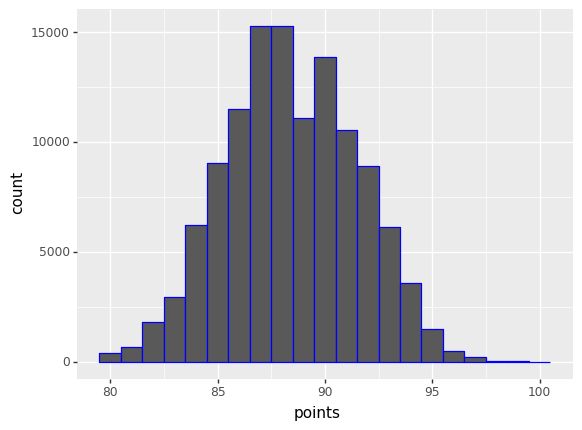

<ggplot: (143292261893)>

In [37]:
ggplot(df) \
+ aes(x='points') \
+ geom_histogram(color='blue', bins=21)

C:\Users\tigra\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 8391 rows containing non-finite values.


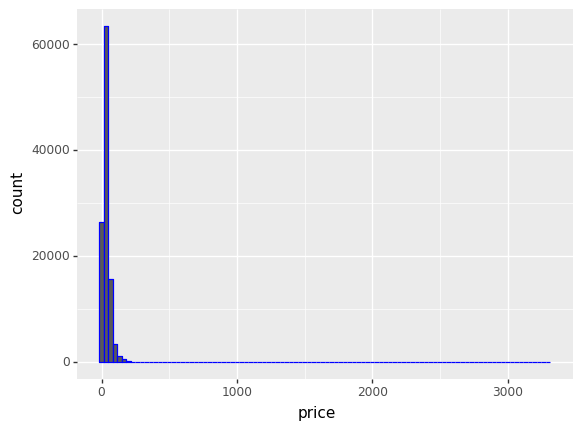

<ggplot: (143297924199)>

In [41]:
ggplot(df) \
+ aes(x='price') \
+ geom_histogram(color='blue', bins=100)

Постороим тот же график, отбросив вина с ценой больше 500, чтобы более детально рассмотреть основную часть данных.

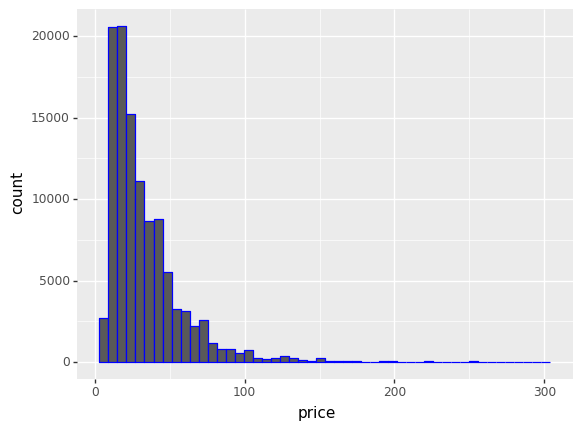

<ggplot: (143298564742)>

In [30]:
ggplot(df[df['price'] < 300]) \
+ aes(x='price') \
+ geom_histogram(color='blue', bins=50)

Для визуализации связи между признаками 'price' и 'points', построим так называемый geom_count график, на котором данные представлены в виде точек, а их размер характеризует количество точек перекрывающих друг друга.

C:\Users\tigra\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_sum : Removed 8391 rows containing non-finite values.


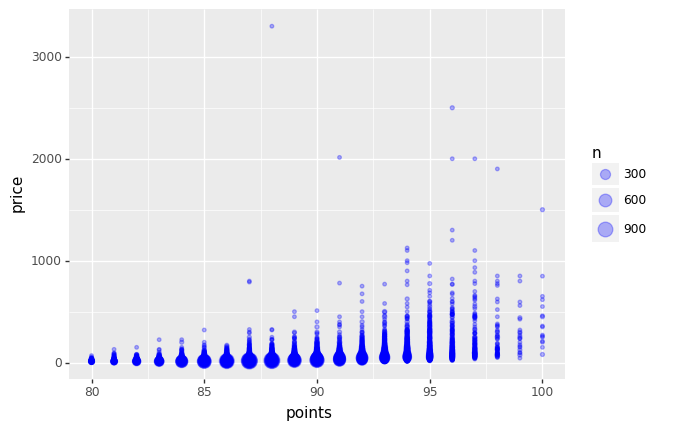

<ggplot: (143291840065)>

In [25]:
ggplot(df) \
+ aes(x='points', y='price') \
+ geom_count(alpha=0.3, color='blue')

Снова отбросим выбросы и посмотрим на распределение поближе. Здесь уже явно видна корреляция между ценой и качеством.

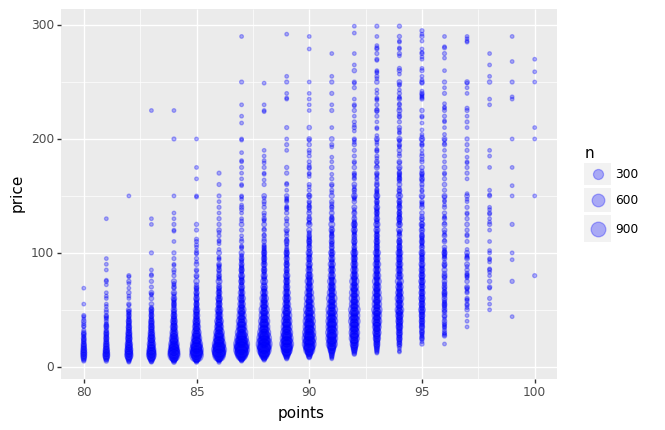

<ggplot: (143289824839)>

In [26]:
ggplot(df[df['price'] < 300]) \
+ aes(x='points', y='price') \
+ geom_count(alpha=0.3, color='blue')

# Часть 2: Творческая

In [18]:
# Имена самых продуктивных авторов отзывов (по числу отзывов)

top_5_tasters = df.groupby(by='taster_name').agg('count')['entry_id'].sort_values(ascending=False).head(5)

top_5_tasters

taster_name
Roger Voss           23558
Michael Schachner    14039
Kerin O’Keefe         9697
Paul Gregutt          8867
Virginie Boone        8708
Name: entry_id, dtype: int64

Вина из каких стран каждый из ТОП-5 оценивает? Сначала посмотрим в каких странах каждый из них работает вообще.

In [19]:
for name in top_5_tasters.index:
    print(f'Дегустатор: {name}')
    print(df[df['taster_name'] == name].groupby(by='country').agg('count')['entry_id'].sort_values(ascending=False))
    print('\n')

Дегустатор: Roger Voss
country
France          17150
Portugal         5223
Austria          1064
Italy              96
South Africa       22
US                  2
Greece              1
Name: entry_id, dtype: int64


Дегустатор: Michael Schachner
country
Spain        6046
Chile        4049
Argentina    3542
Uruguay        98
Italy          76
US             71
Mexico         63
Brazil         49
France         20
Peru           16
Portugal        9
Name: entry_id, dtype: int64


Дегустатор: Kerin O’Keefe
country
Italy    9697
Name: entry_id, dtype: int64


Дегустатор: Paul Gregutt
country
US        8666
Canada     159
France      34
Italy        4
Spain        4
Name: entry_id, dtype: int64


Дегустатор: Virginie Boone
country
US    8708
Name: entry_id, dtype: int64




Теперь выведем основные страны в которых работает каждый дегустатор. За основные примем те в которых он оценил, например, больше 100 вин.

In [20]:
for name in top_5_tasters.index:
    country_count = df[df['taster_name'] == name].groupby(by='country').agg('count')['entry_id']
    print(f"{name}: {country_count.where(country_count > 100).dropna().index.values}\n")

Roger Voss: ['Austria' 'France' 'Portugal']

Michael Schachner: ['Argentina' 'Chile' 'Spain']

Kerin O’Keefe: ['Italy']

Paul Gregutt: ['Canada' 'US']

Virginie Boone: ['US']



Посмотрим как отличаются ценовые диапазоны вин, которые каждый из них оценивает. Будем рассматривать вина дешевле 150 долларов, так как более дорогие вина крайняя редкость в наших данных, и их можно условно считать выбросами.

C:\Users\tigra\AppData\Local\Temp\ipykernel_13188\868543352.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Axes: xlabel='price', ylabel='Density'>

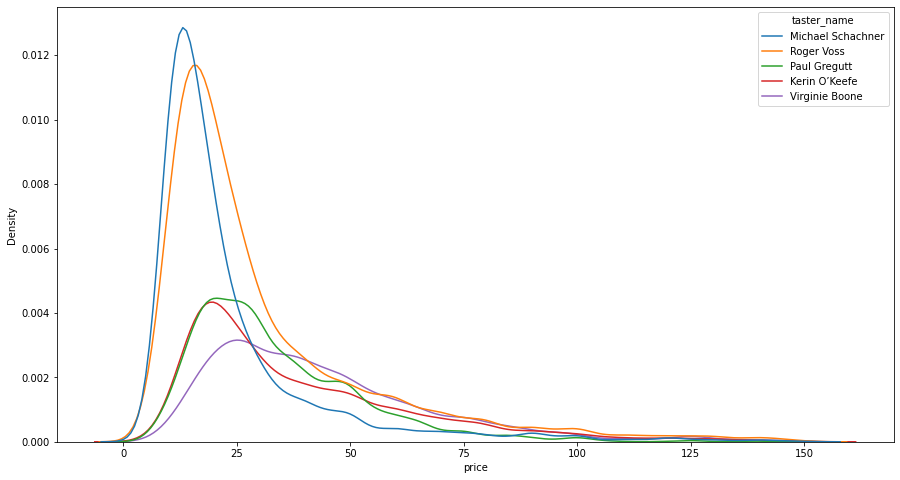

In [21]:
plt.figure(figsize = (15, 8))
sns.kdeplot(data=df[df['taster_name'].isin(top_5_tasters.index)][df['price'] < 150], x='price', hue='taster_name')

C:\Users\tigra\AppData\Local\Temp\ipykernel_13188\1720677845.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Axes: xlabel='taster_name', ylabel='price'>

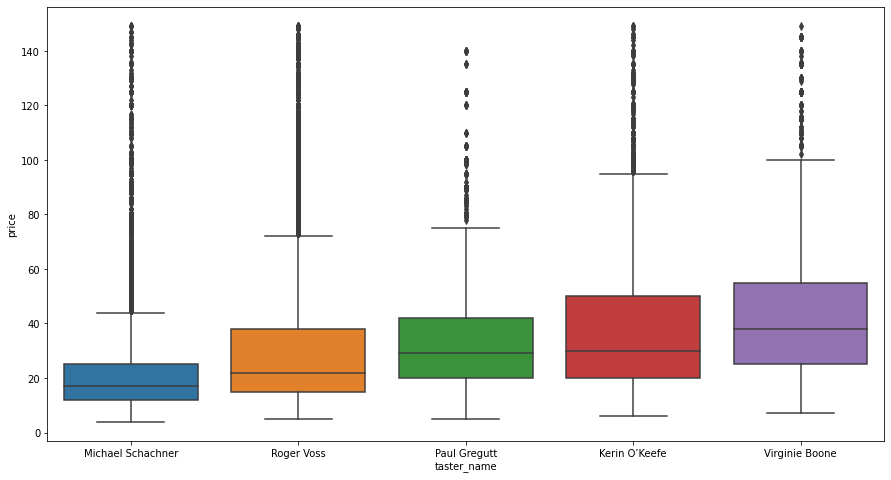

In [22]:
plt.figure(figsize = (15, 8))
sns.boxplot(data=df[df['taster_name'].isin(top_5_tasters.index)][df['price'] < 150], y='price', x='taster_name')

Приведенные графики (особенно второй - box plot) явно демонстрируют, что отличие ценовых диапазонов есть. Хотя каждый из рассматриваемых дегустаторов в целом работает со всеми ценовыми категориями, медианные цены отличаются. 

Посмотрим эти медианные значения.

In [23]:
for name in top_5_tasters.index:
    print(f"Медианная цена вин дегустатора {name}: {df[df['taster_name'] == name]['price'].median()}")
    print()

Медианная цена вин дегустатора Roger Voss: 23.0

Медианная цена вин дегустатора Michael Schachner: 17.0

Медианная цена вин дегустатора Kerin O’Keefe: 30.0

Медианная цена вин дегустатора Paul Gregutt: 29.0

Медианная цена вин дегустатора Virginie Boone: 39.0



# Дополнительное задание

Заказчику очень интересно узнать - что в вине "работает" на высокий рейтинг (90+).
Интересно, какие есть маркеры высокого рейтинга в описании вкуса и в происхождении
вина.

In [22]:
# Общая информация о данных

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119929 entries, 0 to 149907
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   entry_id     119929 non-null  int64  
 1   country      119929 non-null  object 
 2   description  119929 non-null  object 
 3   designation  85394 non-null   object 
 4   points       119929 non-null  int64  
 5   price        111538 non-null  float64
 6   province     119929 non-null  object 
 7   region       100428 non-null  object 
 8   taster_name  95012 non-null   object 
 9   title        119929 non-null  object 
 10  variety      119928 non-null  object 
 11  winery       119929 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 15.9+ MB


In [23]:
# Для удобства, сделаем признак 'entry_id' индексом

df.set_index('entry_id', inplace=True)

In [24]:
# Добавление нового признака показывающего год урожая

df['year'] = df['title'].str.extract('((?:(?:18|19|20)[0-9]{2})|NV)')

In [25]:
# Создание бинарного таргета '90+', который говорит о том является ли рейтинг больше 90

df['90+'] = df['points'] >= 90

Далее заполним пропуски. Для начала оценим их количество.

In [26]:
# Количество пропусков в процентах в каждом признаке

features_with_nan = [feature for feature in df.columns if df[feature].isnull().sum() > 0]
percentage_of_nan = [round(df[feature].isnull().sum() / len(df[feature]) * 100, 2) for feature in features_with_nan]

for i, feature in enumerate(features_with_nan):
    print(f'{feature}: {percentage_of_nan[i]}%, являются пропусками\n')

designation: 28.8%, являются пропусками

price: 7.0%, являются пропусками

region: 16.26%, являются пропусками

taster_name: 20.78%, являются пропусками

variety: 0.0%, являются пропусками



In [27]:
# В категориальных переменных заполним пропуски величиной 'no_info'

df[['designation', 'region', 'taster_name', 'variety']] = df[['designation', 'region', 'taster_name', 'variety']] \
                                                                                                        .fillna('no_info')

Заполнить пропуски в признаке 'price' можно было бы просто медианным значением, но мы поступим умнее. Заполним их предсказанием дерева решений.

In [28]:
# Кодировка категориальных переменных методом one hot encoding

df_dummy = pd.get_dummies(df[['country', 'points', 'year', 'price', 'taster_name']])

In [29]:
# Обучение дерева решений на данных без пропусков

# Подготовка X и y
not_nan_price = df_dummy.dropna()
X_not_nan_price = not_nan_price.drop('price', axis=1)
y_not_nan_price = not_nan_price['price']

# Обучение
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_not_nan_price, y_not_nan_price)

DecisionTreeRegressor()

In [30]:
# Предсказание и заполнение пропущенных цен

X_is_nan_price = df_dummy[df_dummy['price'].isnull()].drop('price', axis=1)
predicted_price = dt_reg.predict(X_is_nan_price)
is_nan_price = X_is_nan_price.assign(price=predicted_price)

df_dummy = pd.concat([is_nan_price, not_nan_price])

df.drop('price', axis=1, inplace=True)
df = pd.concat([df, df_dummy['price']], axis=1)

Для нахождения маркеров высокого качества вина в признаках описывающих происхождение вина, обучим случайный лес на этих признаках и посмотрим его feature importance

In [31]:
# Приготовка X и y

X_origin = pd.get_dummies(df[['country', 'province', 'region']])
y_origin = df['90+']

In [32]:
# Количество признаков после кодирования

X_origin.shape[1]

1698

In [33]:
%%time
# Обучение модели

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15)
rf_clf.fit(X_origin, y_origin)

CPU times: total: 34.1 s
Wall time: 34.1 s


RandomForestClassifier(max_depth=15)

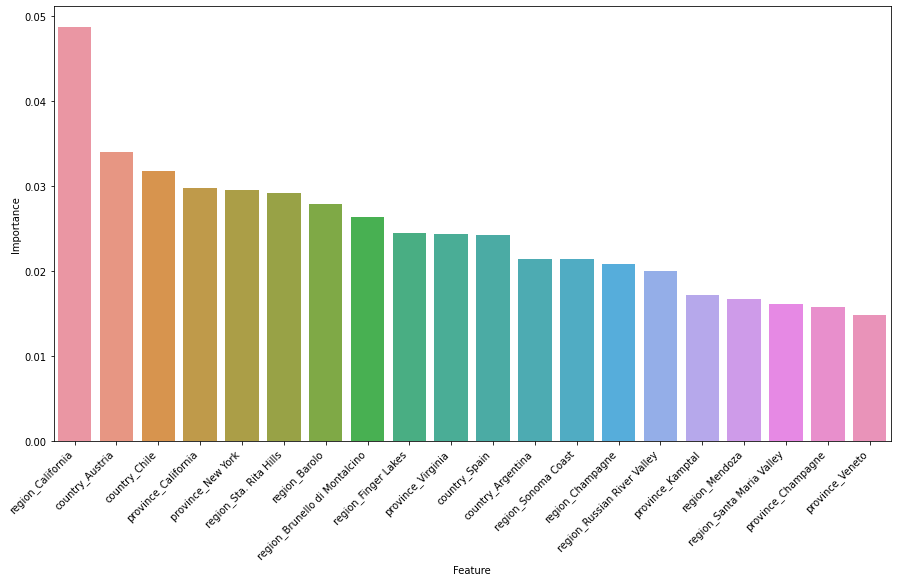

In [34]:
# Выведем на bar plot 20 самых важных признаков

features_amount = 20

importance_df = pd.DataFrame({'Feature': X_origin.columns, 'Importance': rf_clf.feature_importances_}) \
                  .sort_values(by='Importance', ascending=False)

plt.figure(figsize = (15, 8))
plt.xticks(rotation = 45, ha='right')
sns.barplot(data=importance_df.head(features_amount), x='Feature', y='Importance');

Здесь показаны фичи, которые сильнее всего влияют на таргет, однако на данном графике не понятно является это влияние положительным или негативным. Для этого постороим следующие графики.

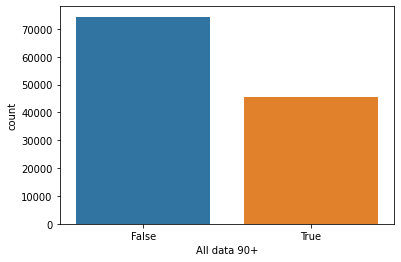

In [35]:
# Распределение таргета на всех данных

sns.countplot(data=df, x='90+').set(xlabel='All data 90+');

In [36]:
# Отношение количества вин с рейтингом выше 90 к количеству вин с рейтингом ниже 90 на всех данных

proportion_all = np.round(df[df['90+'] == True].shape[0] / df[df['90+'] == False].shape[0], 2)
print(f"T/F = {proportion_all}")

T/F = 0.61


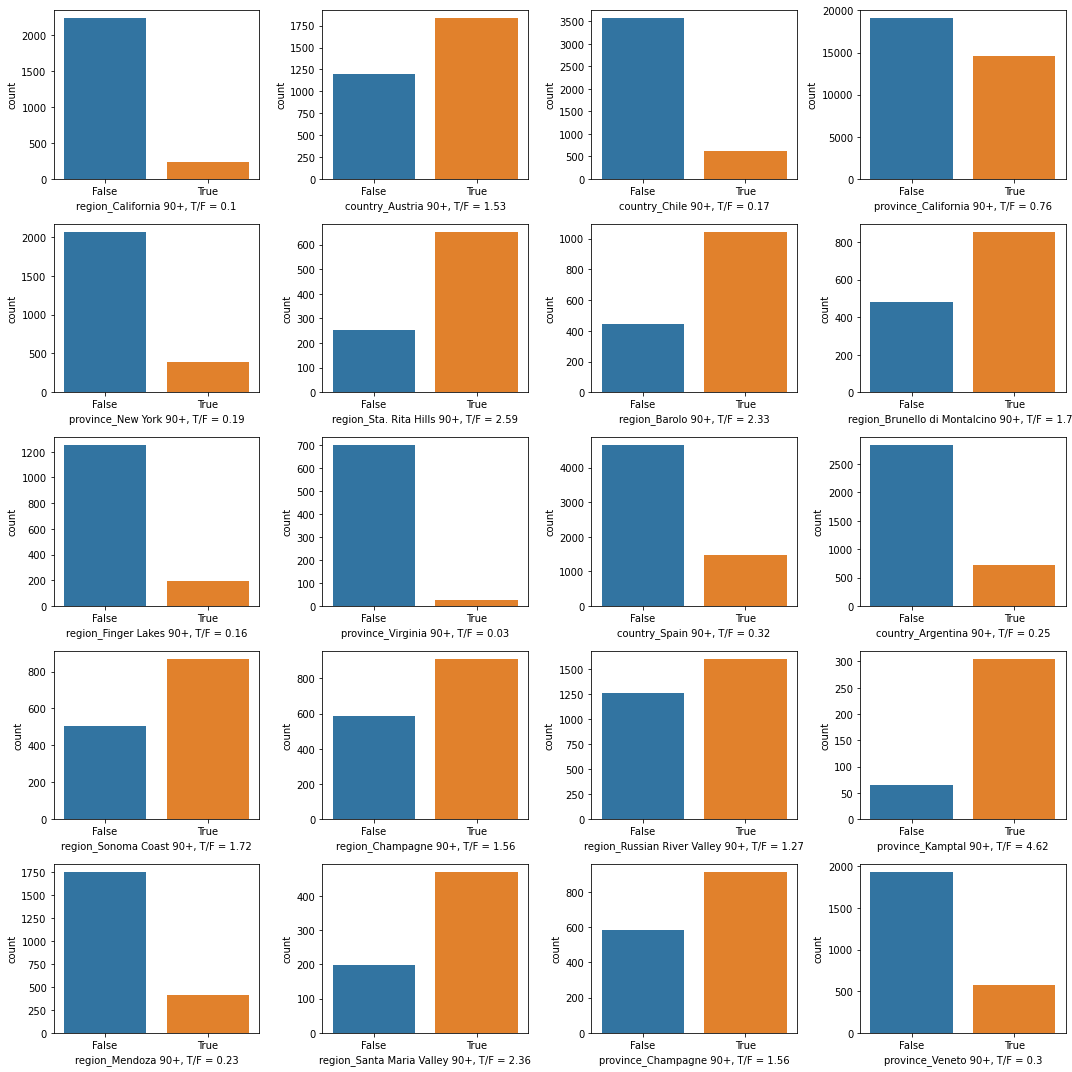

In [37]:
# Распределение таргета на каждом из 20-ти самых важных признаков

proportions_list = [] # Список, в котором будут отношениями T/F каждого признака
important_features = importance_df['Feature'].head(features_amount)

fig, axs = plt.subplots(5, 4, figsize=(15, 15))

for i, feature in enumerate(important_features):
    data = df[df[feature.split('_')[0]] == feature.split('_')[1]]
    proportions_list.append(np.round(data[data['90+'] == True].shape[0] / data[data['90+'] == False].shape[0], 2))
    
    proportion = proportions_list[i]
    
    sns.countplot(data=data, x='90+', ax=axs[i//4, i%4]) \
       .set(xlabel=f'{feature} 90+, T/F = {proportion}')
    
plt.tight_layout()

Сравнивая соотношение T/F каждого признака с этим соотношением на всех данных, можно понять в какую сторону влияет признак. Постоим окончательный график, на котором красным будут окрашены признаки, влияющие отрицательно, а зеленым положительно.

<BarContainer object of 20 artists>

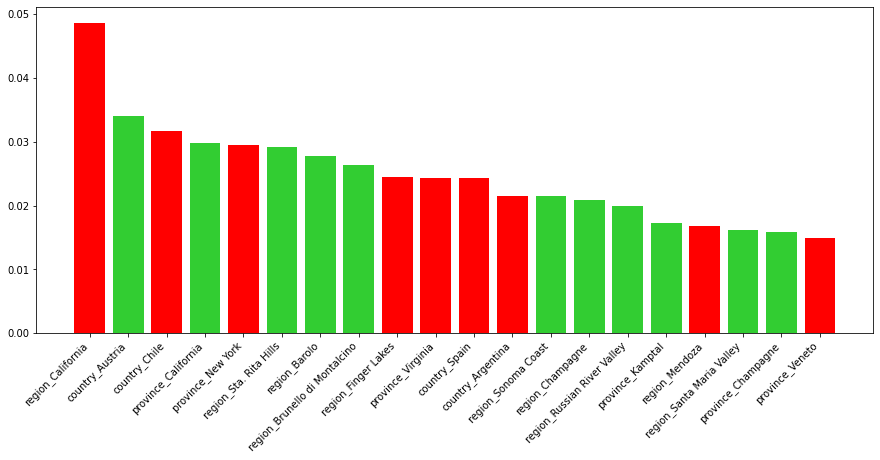

In [38]:
plt.figure(figsize = (15, 6))
plt.xticks(rotation = 45, ha='right')
plt.bar(x=importance_df.head(features_amount)['Feature'], height=importance_df.head(features_amount)['Importance'], 
        color=["red" if -proportion_all + proportion < 0 else "limegreen" for proportion in proportions_list])

Теперь перейдем к нахождению маркеров высокого качества вина в описании (признак 'description'). Для этого токенизируем слова из всего набора описаний и воспользуемся логистической регрессией. Так мы получим "вероятности" отнесения вина к тому или иному классу целевой переменной, при наличии конкретного слова в описании. Далее выделим слова, которые сильнее всего влияют на целевую переменную.

In [39]:
# Токенизируем слова

cv = CountVectorizer()
cv.fit(df['description'])

CountVectorizer()

In [40]:
# Количество токенов в полученном "мешке слов"

len(cv.vocabulary_)

31266

In [41]:
# Подготовка X и y
X_text = cv.transform(df['description'])
y_text = df['90+']

# Обучение модели
logit = LogisticRegression(n_jobs=-1)
logit.fit(X_text, y_text)

LogisticRegression(n_jobs=-1)

In [42]:
# Отбор наибольших и наименьших коэффициентов

words_amount = 30

coef = logit.coef_.ravel()
positive_coefficients = np.argsort(coef)[-words_amount:]
negative_coefficients = np.argsort(coef)[:words_amount]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

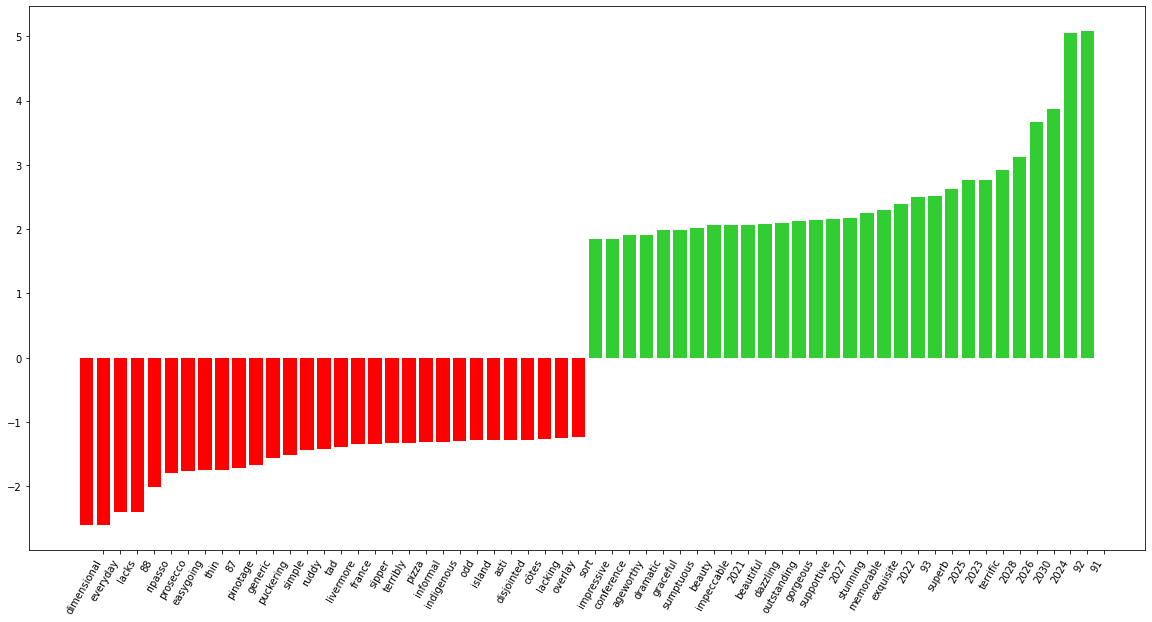

In [43]:
# Визуализация

plt.figure(figsize=(20, 10))
colors = ["red" if c < 0 else "limegreen" for c in coef[interesting_coefficients]]
plt.bar(np.arange(2 * words_amount), coef[interesting_coefficients], color=colors)
plt.xticks(np.arange(1, 1 + 2 * words_amount),
           np.array(cv.get_feature_names_out())[interesting_coefficients],
           rotation=60,
           ha="right");

На полученом графике представлены наболее значимые слова. Кросным обозначены слова влияющие отрицательно, а зеленым положительно.

Кроме обычных прилагательных, описывающих вкус вина, мы можем видеть множество чисел. Попробуем разобраться в их смысле. Для этого рассмотрим несколько примеров их использования в тексте.

In [44]:
# Пример использования '91' в тексте

df[df['description'].str.contains('91')]['description'].iloc[1]

'91-93 The wine is tight, densely textured, very firm in character. It has considerable weight to go with the sweet fruit, very powerful.'

Из этого примера становится ясно, что дегустаторы в описании иногда явно прописывают рейтинг вина, отсюда и очевидная прямая зависимость.

Чтобы понять откуда такая сильная взаимосвязь высокого рейтинга вина с некоторыми годами ('2024', '2030', '2026' и т.д.) посмотрим на 5 примеров описаний вин с высоким рейтингом и 5 с низким.

In [45]:
# 5 примеров высокого рейтинга

for i in range(5):
    print(df[df['90+'] == True]['description'].iloc[i])
    print()

Raspberry and cassis aromas are fresh and upright while showing wiry, grassy accents. Full bodied, this features a jammy, pulpy palate that's fresh but low on definition. Herbal, lightly green infiltrations drift onto a solid, tannic finish. Drink through 2018.

Compared to the regular 2006 Malbec from Chakana, this wine steps up in weight class and wins the crown. It's a serious but inviting red with spongey, ripe berry aromas topped by pure raspberry, cherry and cola flavors. It's both racy and composed, with a pile of bitter chocolate on the long finish. Good through 2009 at least.

Andeluna's top wines tend to be ripe and plump, and so they come across as easy to drink and less demanding. This blend of Malbec, Cabernet Sauvignon, Merlot and Cabernet Franc is devoid of astringency and hard tannins. It's ripe, just a little rugged, and integrated such that the berry flavors are forward and don't need to fight to be appreciated.

A lively, well-made blend of Tempranillo, Malbec and Sy

In [46]:
# 5 примеров низкого рейтинга

for i in range(5):
    print(df[df['90+'] == False]['description'].iloc[i])
    print()

Potent and herbal, this has aromas of tomato, olive, mineral and tobacco. It feels tight, drying and lively, with herb-infused flavors of plum and berry along with spicy oak. Rich in feel, but it's distinctly foresty and herbal tasting on the finish. This is 100% Malbec with an undeniable Salta imprint.

Earthy, oaky aromas of roasted berry, tree bark, root extract and lemongrass are jumbled but not unpleasant. This feels blocky and heavy upfront, then more hollow as it breathes. Flavors of prune and black fruits are stewy, while chocolate, coffee and herbal notes steer a heavy finish.

Compost aromas blend with thicker, richer raisiny notes. This feels deep and almost heavy on the palate, where the acidity is modest and stewed, with hints of herbal flavor. Black currant and blackberry come across fully ripe. Notes of coffee, herbs and salt dictate the finishing flavors on this huge Malbec.

With its light color, minerally nectarine aromas and Provence leanings, this is a good facsimil

Из этих примеров можно предположить, что зачастую, если дегустатор рекомендует вино, он в конце пишет в какие годы вкус вина раскроется лучше всего. Если же вкус вина ему не понравился, то такого комментария нет.

# Выводы по дополнительной части

В дополнительной части были очищены и трансформированы данные. Пропуски в категориальных признаках заменены на значение 'no_info', а в признаке 'price' заменены с помощью предсказания дерева решений.

Также с помощью модели случайного леса получены самые важные признаки связаные с происхождением вина. Далее путем сравнения распределения таргета на всем наборе данных с распределениями на важных признаках выявлен знак их влияния на целевую переменную.

Для выявления маркеров качества вина в признаке 'description' был получен так называемый мешок слов и обучена модель логистической регрессии. в результате получены слова имеющие наибольшую связь с качеством вина и величины этих связей.